In [1]:
from astropy.io import ascii
import numpy as np
from astropy import table

from scipy.interpolate import interp1d


from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
def read_data(fspec, fsed):
    # read data
    spec = ascii.read(fspec, format='fixed_width')
    sed = ascii.read(fsed)
    sed = sed[1:]
    return spec, sed

In [6]:
def compute_cal(spec, sed, fsed, PLOT=True):
    dw = np.mean( np.diff(sed["col1"][1:]) )
    spec_binned = []
    for w in sed["col1"]:
        ii  = spec["wl"] >= w-dw/2.
        ii *= spec["wl"] <  w+dw/2.
        spec_binned.append( np.mean(spec["count"][ii]) )
    spec_binned = np.array(spec_binned)


    cal = sed["col2"]/spec_binned
    cal_interp = interp1d(sed["col1"], cal, kind='cubic', bounds_error=False)
    
    if PLOT:
        f = np.mean(cal)
        fig = plt.figure(figsize=[15,5])
        plt.title("Foo")

        plt.subplot(131)
        plt.plot(sed["col1"],sed["col2"],'x')
        plt.plot(spec["wl"],spec["count"]*f,'b-', alpha=.5)
        plt.plot(sed["col1"],spec_binned*f,'bo')
        plt.ylabel("erg/s/cm^2/A")
        plt.xlabel("wavelength [A]")

        ax2 = plt.subplot(132)
        plt.plot(sed["col1"],cal,'s')
        plt.plot(sed["col1"],cal_interp(sed["col1"]),'k-')
        plt.ylabel("erg/s/cm^2/A")
        plt.xlabel("wavelength [A]")
        plt.text(.5,1.05,fsed, transform=ax2.transAxes,ha='center',va='bottom')


        plt.subplot(133)
        plt.plot(sed["col1"],spec_binned*cal,'bo')
        plt.plot(sed["col1"],sed["col2"],'kx')
        plt.plot(spec["wl"],spec["count"]*cal_interp(spec["wl"]),'b-', alpha=.5)
        plt.ylabel("erg/s/cm^2/A")
        plt.xlabel("wavelength [A]")
        fig.tight_layout()
        
        return sed["col1"], cal, spec_binned


In [7]:
def do_cal(cal_star_id):
    
    fsed = "000001_{}.txt".format(cal_star_id)
    fspec = "{}.txt".format(cal_star_id)
    fcalout = "{}_cal.txt".format(cal_star_id)

    # read data
    spec, sed = read_data(fspec, fsed)

    #compute calibration
    ww, cal, spec_binned = compute_cal(spec, sed, fsed)

    # write calibration
    tcal = table.Table(data=[ww, cal, spec_binned], dtype=[float,float, float], names=["wl[A]","cal[erg/s/cm^2/A/cnt]","counts"])
    tcal.write(fcalout, overwrite=True, format="ascii.fixed_width")

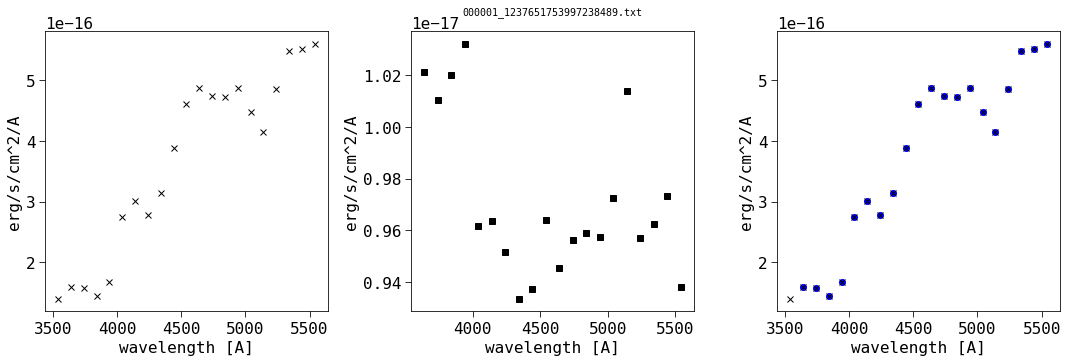

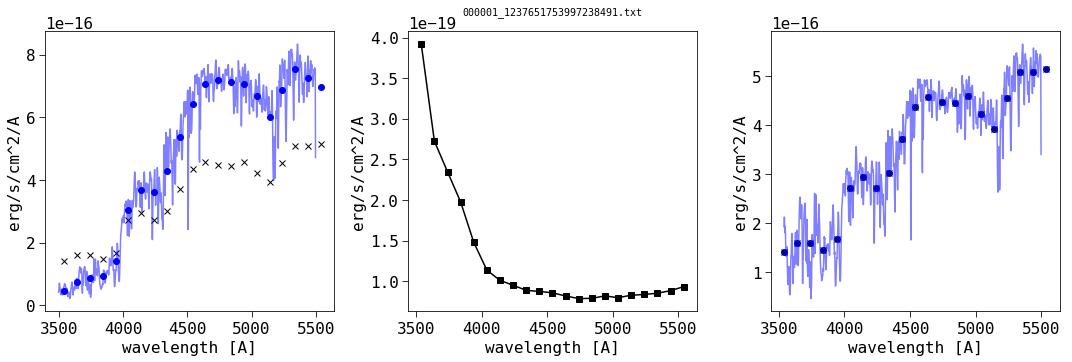

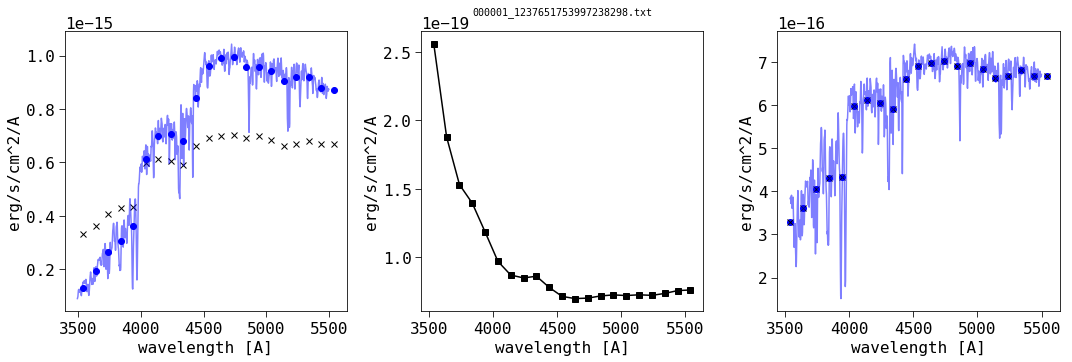

In [8]:
#cal_star_ids = [
#            '1237651753997238489',
#            '1237651753997238298',
#            '1237651753997238491',
#            #'1237651753997172794',
#            #'1237651753997238386'
#            ]

cal_star_ids = [
    #'1237651753997303899', # no SED
    #'1237651753997304139', # Galaxy
    #'1237651753997238991', # Galaxy
    '1237651753997238489',
    #'1237651753997238926', # Galaxy
    #'1237651753997238511', # no SED
    '1237651753997238491',
    #'1237651753997238477', # no SED
    '1237651753997238298',
    #'1237651753997172947', # no SED
    #'1237651753997172794', # Galaxy
]

for cal_star_id in cal_star_ids:
    do_cal(cal_star_id)

NameError: name 'wlmax' is not defined

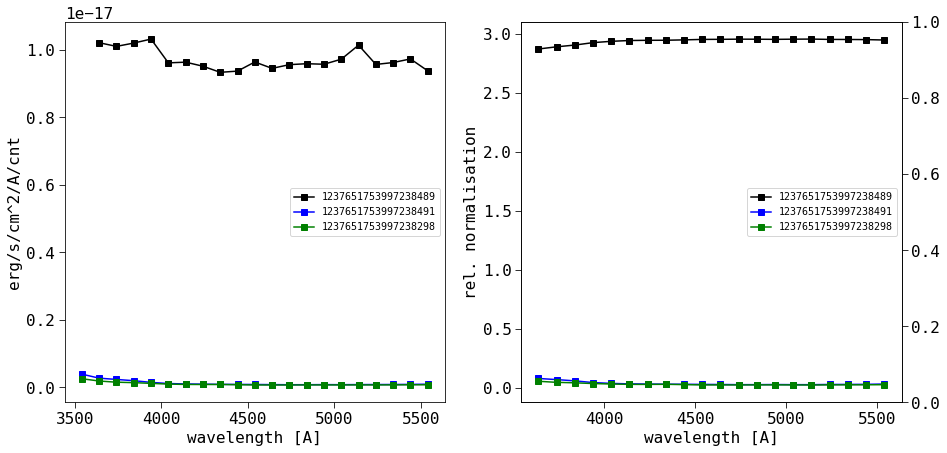

In [9]:
f = plt.figure(figsize=[15,7])

ax1 = plt.subplot(121)
all_cal = []
all_cnt = []
for cal_star_id in cal_star_ids:
    fcalout = "{}_cal.txt".format(cal_star_id)
    tcal = ascii.read(fcalout, format='fixed_width')
    all_cal.append(tcal['cal[erg/s/cm^2/A/cnt]'])
    all_cnt = [tcal['counts']]
    plt.plot(tcal['wl[A]'],tcal['cal[erg/s/cm^2/A/cnt]'],'s-', label=cal_star_id)
plt.legend()
plt.ylabel("erg/s/cm^2/A/cnt")
plt.xlabel("wavelength [A]")


ax2 = plt.subplot(122)
all_cal = np.array(all_cal)
all_cnt = np.array(all_cnt)
mall_cal = np.mean(all_cal, axis=0)

for cal_star_id in cal_star_ids:
    fcalout = "{}_cal.txt".format(cal_star_id)
    tcal = ascii.read(fcalout, format='fixed_width')
    plt.plot(tcal['wl[A]'],tcal['cal[erg/s/cm^2/A/cnt]']/mall_cal,'s-', label=cal_star_id)
plt.legend()
#plt.ylabel("erg/s/cm^2/cnt")
plt.xlabel("wavelength [A]")
plt.ylabel("rel. normalisation")
plt.twinx()


ss = []
mm = []
wmm = [] # weighted mean
ws = []
ww = tcal['wl[A]']
for i,w in enumerate(ww):
    s = np.std( all_cal[:,i] )
    m = np.mean( all_cal[:,i] )
    wm = np.mean( all_cal[:,i]*all_cnt[:,i] )/np.sum(all_cnt[:,i])
    w = (wlmax+wlmin)/2.
    ss.append(s)
    ws.append(w)
    mm.append(m)
    wmm.append(wm) # form weighted mean
plt.plot(ww,ss/m,drawstyle='steps-mid')
plt.ylabel("rel. sigma of normalisation")

ax1.plot(ww,wmm,'r-', lw=4, alpha=.5)


print(ss/m)

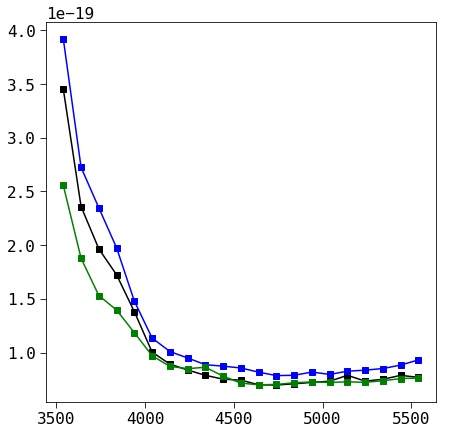

In [197]:

f = plt.figure(figsize=[7,7])
for cal_star_id in cal_star_ids:
    
    fcalout = "{}_cal.txt".format(cal_star_id)
    tcal = ascii.read(fcalout, format='fixed_width')
    
    plt.plot(tcal['wl[A]'],tcal['cal[erg/s/cm^2/A/cnt]'],'s-')

In [198]:
tmeancal = table.Table(data=[ww, mm], names=['wl[A]','cal[erg/s/cm^2/A/cnt]'], dtype=[float,float])

tmeancal.write("mean_cal.txt", format='ascii.fixed_width')

In [199]:
!cat mean_cal.txt

|  wl[A] |  cal[erg/s/cm^2/A/cnt] |
| 3540.0 | 3.3094430783446566e-19 |
| 3640.0 | 2.3205882484041984e-19 |
| 3740.0 |  1.947893302066503e-19 |
| 3840.0 | 1.6981768580528708e-19 |
| 3940.0 |  1.348025913376124e-19 |
| 4040.0 | 1.0364686691361835e-19 |
| 4140.0 |  9.239603361234845e-20 |
| 4240.0 |  8.786877647726347e-20 |
| 4340.0 |  8.453829843555037e-20 |
| 4440.0 |  8.015811024591912e-20 |
| 4540.0 |  7.712190220407825e-20 |
| 4640.0 |  7.386286583564343e-20 |
| 4740.0 |  7.282396730960258e-20 |
| 4840.0 |   7.38322322697977e-20 |
| 4940.0 |  7.551254845792635e-20 |
| 5040.0 |  7.498868205144773e-20 |
| 5140.0 |  7.800960327168345e-20 |
| 5240.0 |  7.639422276371242e-20 |
| 5340.0 |  7.794780055723625e-20 |
| 5440.0 |  8.091035160955135e-20 |
| 5540.0 |  8.206570785687741e-20 |


In [200]:
1237651753997304198
1237651753997303899
1237651753997304139
1237651753997238991
1237651753997238489
1237651753997238926
1237651753997238511
1237651753997238491
1237651753997238477
1237651753997238298
1237651753997238529
1237651753997172947
1237651753997172794
1237651753997173416


000001_1237651753997172794.txt
000001_1237651753997238292.txt
000001_1237651753997238298.txt
000001_1237651753997238347.txt
000001_1237651753997238348.txt
000001_1237651753997238386.txt
000001_1237651753997238452.txt
000001_1237651753997238453.txt
000001_1237651753997238489.txt
000001_1237651753997238491.txt



SyntaxError: invalid token (<ipython-input-200-601d7efcda15>, line 17)